In [2]:
import numpy as np
import tal
import matplotlib.pyplot as plt
import matplotlib

from phasor_fields import phasor_fields_reconstruction, phasor_fields_filter
from zero_phase_corrector import adaptive_z_reconstruction
from backprojection import back_projection
from visualizer import StreakPlotter

import time

%load_ext autoreload
%autoreload 2

In [12]:
# src = '../nlos_dataset/3d_small_planes/'
# data_file = '2d_3_plane.hdf5'
# data_file = '2d_1_plane_center.hdf5'
# data_file = '2d_1_plane_center_tilted.hdf5'
# data_file = '2d_2_planes_center_smaller_1cm.hdf5'
# data_file = '2d_2_planes_center_smaller_1mm.hdf5'
# data_file = '2d_2_planes_center_smaller_100um.hdf5'
# data_file = '2d_2_planes_center_smaller_10um.hdf5'
# data_file = '2d_2_planes_center_smaller_1um.hdf5'
# data_file = '2d_1_plane_right.hdf5'
# data_file = '2d_1_plane_right_tilted.hdf5'
# data_file = '2d_2_planes_center_right.hdf5'
# data_file = '2d_2_planes_center_right_nmc.hdf5'
# data_file = '2d_2_planes_left_right.hdf5'
# src = '../nlos_dataset/mesh_R_256x256/front/'
# data_file = 'data.hdf5'; switch_indices=lambda data: data.swapaxes(0, -1)
# src = '../nlos_dataset/'
# data_file = 'performat_letter4.hdf5'
# switch_indices=lambda data: np.moveaxis(data, 0, 2)

# src = '../nlos_dataset/3d_small_planes/20240611-194813/'
# data_file = 'plane1_z[2.5]_x[0.0]_rot[0].hdf5'
src = '../nlos_dataset/3d_small_planes/hdf5_ln_files/'
data_file = 'plane1_z[1.0]_x[0.0]_rot[0].hdf5'

# Volume definition 
delta_z = 0.0001
z_begin = 0.5
z_end = 1.5
# PF filter definition
starting_central_wavelength = 0.2
ending_central_wavelength = 0.05
n_pulses = 5

# Number of threads
n_threads = 1

In [13]:
z_grid = np.mgrid[z_begin:z_end:delta_z]

full_path = src + data_file
data = tal.io.read_capture(full_path)

medium_idx = data.H.shape[2]//2
data.H = data.H[:,:,medium_idx:-medium_idx+1]
# Capture grid
data.sensor_grid_xyz = data.sensor_grid_xyz[:,medium_idx:-medium_idx+1]
gt_medium_idx = data.hidden_depth_grid_xyz.shape[1]//2
data.hidden_depth_grid_xyz = data.hidden_depth_grid_xyz.swapaxes(0,1)[-1:0:-1,gt_medium_idx:-gt_medium_idx+1,...]
data.hidden_depth_grid_normals = data.hidden_depth_grid_normals.swapaxes(0,1)[-1:0:-1,:,gt_medium_idx:-gt_medium_idx+1,...]
# Illumination point
xl = data.laser_grid_xyz[0,0]

# V_coords = np.array(np.meshgrid(data.sensor_grid_xyz[:,0,0],
#                                 data.sensor_grid_xyz[0,:,1],
#                                 z_grid)).swapaxes(0,-1)

V_coords = data.sensor_grid_xyz \
            + np.array([0,0,1])*z_grid.reshape(-1, 1, 1, 1)


../nlos_dataset/3d_small_planes/hdf5_ln_files/plane1_z[1.0]_x[0.0]_rot[0].hdf5 is a link. Following link...


In [14]:
s_pf_dense = time.time()
pf_analysis = {}
dense_V = phasor_fields_reconstruction(data, ending_central_wavelength, 
                                        n_pulses, z_begin, z_end, delta_z, 
                                        xl, n_threads = n_threads, 
                                        analysis=pf_analysis)
e_pf_dense = time.time()

s_adaptive = time.time()
adaptive_analysis = {}
result_coordinates = adaptive_z_reconstruction(data,
                                                starting_central_wavelength,
                                                ending_central_wavelength,
                                                n_pulses, z_begin, z_end, 
                                                xl, n_threads = n_threads,
                                        analysis_result=adaptive_analysis)
e_adaptive = time.time()
max_coords_V, zero_phase_point = result_coordinates

print(f'Dense reconstruction took {e_pf_dense - s_pf_dense}.')
for key in pf_analysis:
    print(f'\t{key}: {pf_analysis[key]}')
print(f'Adaptive reconstruction took {e_adaptive - s_adaptive}.')
for key in adaptive_analysis:
    print(f'\t{key}: {adaptive_analysis[key]}')

reconstruction:   0%|          | 11/10000 [00:00<01:36, 103.34it/s]

reconstruction: 100%|██████████| 1/1 [00:00<00:00, 74.06it/s]

Dense reconstruction took 100.98304796218872.
	kernels used: 2550000
	reconstructed voxels: 1280000
Adaptive reconstruction took 0.5675442218780518.
	reconstructed voxels: 2048
	iterations: 3
	total kernels used: 4080


In [15]:
# Save the results
np.save('dense_reconstruction', dense_V)
np.save('adaptive_depth', max_coords_V)
np.save('adaptive_zero_phase', zero_phase_point)

In [16]:
# # Applies backprojection
# wl, weights, fH = phasor_fields_filter(ending_central_wavelength, 
#                                         n_pulses, data,False)
# filtered_H = np.sum(weights.reshape(-1,1,1,1)*fH[:,np.newaxis] * np.exp((2j*np.pi/wl.reshape(-1,1,1,1))*np.arange(data.H.shape[0]).reshape(-1,1,1)*data.delta_t), axis = 0)
# dense_V_bp = back_projection(V_coords, filtered_H, data.sensor_grid_xyz, 
#                             data.laser_grid_xyz, data.delta_t, 
#                             n_threads = n_threads)
# np.save('dense_reconstruction_bp', dense_V_bp)

In [17]:
# plt.plot(filtered_H[1600:1750, 0, 64]/ np.max(filtered_H[:, 0, 64]) )
# plt.plot(np.abs(filtered_H[1600:1750, 0, 64]/ np.max(filtered_H[:, 0, 64])) )
# # np.convolve(data.H[:])
# pulse = np.sum(weights.reshape(-1,1)* np.exp((2j*np.pi/wl.reshape(-1,1))*np.arange(data.H.shape[0])*data.delta_t), axis = 0)
# plt.plot(pulse / np.max(pulse))
# plt.show()

In [18]:

plotter = StreakPlotter(V_coords, 'dense_reconstruction.npy', 
                                    'adaptive_depth.npy',
                                    'adaptive_zero_phase.npy',
                                    data.hidden_depth_grid_xyz)

# plotter = StreakPlotter(V_coords, 'dense_reconstruction_4r.npy', 
#                                     'adaptive_depth_4r.npy',
#                                     'adaptive_zero_phase_4r.npy',
#                                     data.hidden_depth_grid_xyz)
plotter[:,0].plot()

d:\Documentos\NLOS\zero_phase_NLOS\visualizer.py:73: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_yticklabels(["{:0.4f}".format(tick) for tick in ytick_label] )


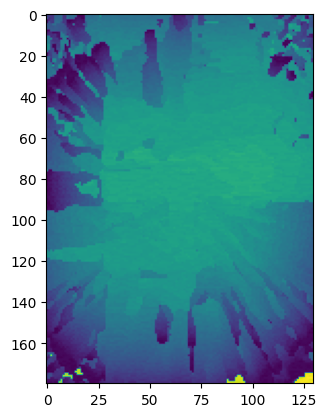

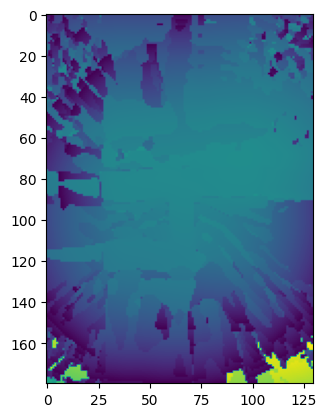

In [3]:
zero_phase_4r = np.load('results/preformat_4letter/adaptive_zero_phase_4r.npy')
dense_4r = np.load('results/preformat_4letter/dense_reconstruction_4r.npy')

plt.imshow(zero_phase_4r[:,2].reshape(dense_4r.shape[1:]))
plt.show()
plt.imshow(np.argmax(dense_4r, axis = 0))
plt.show()